# HelloWorld！
简易示例程序

In [16]:
from TextProcessor import *

import os
import math
import datetime
import jieba
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, LSTMCell, LSTM, Bidirectional
from tensorflow.keras.layers import TextVectorization

# 1 分词，取高频词标注词性【人工】

In [2]:
# 读取数据和词频统计
total = pd.read_csv('data/webnews/2010.csv', usecols=['Newstitle'], encoding='utf-8-sig')
total.drop_duplicates(inplace=True)

In [3]:
# 清洗和分词，统计词频
wordcount = generate_word(total['Newstitle'] ,clearfy=True)

Building prefix dict from the default dictionary ...
Dumping model to file cache /var/folders/jw/c7byzd457pxcb_zjhzf_fjq40000gn/T/jieba.cache
Loading model cost 0.376 seconds.
Prefix dict has been built successfully.


In [4]:
wordcount

,word,count
0,月,25027
1,年,23984
2,日,21447
3,股份,19182
4,提示,16325
...,...,...
74067,振东,1
74068,振兮扬,1
74069,振动,1
74070,振威,1


dictionary size (counts >= 2000): 130
dictionary size (counts >= 2000): 327


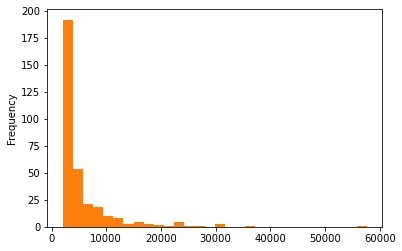

In [5]:
# 生成词典
# 根据wordcount生成新词典
worddict = generate_dict(wordcount, 2000)
worddict.to_csv('dict/Worddict_sample.csv', index=False, encoding='utf-8-sig')

# 读取旧词典
olddict = pd.read_csv('dict/old/olddict.csv', encoding='utf-8-sig')
worddict = generate_dict(wordcount, threshold=2000, merge=True, mergedict=olddict)
worddict.to_csv('dict/Worddict_sample.csv', index=False, encoding='utf-8-sig')

## 人工标注...

分类标签  
sentiment：1-负面，2-中性，3-正面  
topic：0-无主题，1-公司业绩，2-产品，3-股价和融资，4-公司重大事项或董事会行为

# 2 基于关键词初步分类

In [6]:
# 读取字典，去除未标记的
worddict = pd.read_csv('dict/Worddict_edit.csv', encoding='utf-8-sig')
worddict = worddict.dropna(subset=['sentiment'])
worddict = worddict[~( (worddict['sentiment']==2) & (worddict['topic'].isna()) )].copy()

In [8]:
# 关键词分类
result = pre_classify(
    text = total['Newstitle'], 
    dictionary= worddict, 
    feature='sentiment', 
    value=[1,3], 
    absolute=True
    )

Processing: 1
Processing: 3


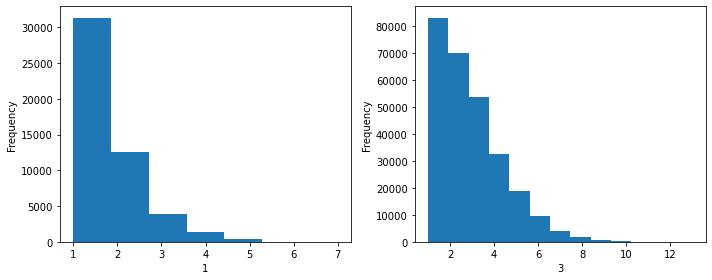

In [17]:
# 看评分分布
plot_score(result=result, feature='sentiment', classes=[1,3], wide=2)

In [76]:
neg = result[(result['sentiment']=='1') & (result['score']>=3)].sort_values(by='score', ascending=False).drop_duplicates()
pos = result[(result['sentiment']=='3') & (result['score']>=7)].sort_values(by='score', ascending=False).drop_duplicates()
mid = result[(result['score']==0) & (result[1]==0)].copy()
mid['sentiment'] = 2

# 保存成训练集
data = pd.concat([pos,neg,mid], ignore_index=True)
# 处理文本，分词
stopwords = pd.read_csv('dict/stopword.csv', encoding='utf-8-sig')
data['Newstitle'] = clean_text(data['Newstitle'], stopwords['Coname'].to_list())
data.dropna(inplace=True)
data.drop_duplicates('Newstitle',inplace=True)
data[['Newstitle', 'sentiment']].to_csv('output/sample.csv', index=False, encoding='utf-8-sig')

## 人工检查...(可选)

# 3 循环1: 样本自检

In [9]:
# 读取样本
data = pd.read_csv('output/sample.csv', encoding='utf-8-sig')
data.dropna(inplace=True)
data.reset_index(inplace=True, drop=True)

## 3.1 词向量化和TensorFlow模型

In [19]:
model = use_default_model(data['Newstitle'], data['sentiment'])

2022-05-05 23:40:04.473511: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 1/5


2022-05-05 23:40:06.717879: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-05 23:40:06.929913: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-05 23:40:06.940994: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-05 23:40:07.782478: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-05 23:40:07.797895: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


668/668 [==============================] - ETA: 0s - loss: 0.3441 - accuracy: 0.8661

2022-05-05 23:40:25.051572: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-05 23:40:25.130643: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-05 23:40:25.137953: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


668/668 [==============================] - 23s 30ms/step - loss: 0.3441 - accuracy: 0.8661 - val_loss: 0.0716 - val_accuracy: 0.9854
Epoch 2/5
668/668 [==============================] - 19s 28ms/step - loss: 0.0728 - accuracy: 0.9886 - val_loss: 0.0257 - val_accuracy: 0.9937
Epoch 3/5
668/668 [==============================] - 19s 28ms/step - loss: 0.0349 - accuracy: 0.9978 - val_loss: 0.0242 - val_accuracy: 0.9949
Epoch 4/5
668/668 [==============================] - 19s 28ms/step - loss: 0.0199 - accuracy: 0.9996 - val_loss: 0.0266 - val_accuracy: 0.9956
Epoch 5/5
668/668 [==============================] - 19s 29ms/step - loss: 0.0126 - accuracy: 0.9997 - val_loss: 0.0298 - val_accuracy: 0.9961


## 3.2 样本检查
自检使用本身的样本data

In [100]:
result = classify(model, data['Newstitle'].to_list(), [1,2,3], 'sentiment')
diff, idx = compare(data, result, 'sentiment')

2022-05-02 19:51:58.574937: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [103]:
diff

,Newstitle,sentiment,1,2,3,sentiment,score
467,推出 首款 量产 混合 动 轿车,3,0.098667,0.825490,0.075843,2,0.825490
822,中国 南车 大 股东 拟 亿 护盘 新一轮 增持潮 再现,3,0.741825,0.088574,0.169601,1,0.741825
1226,亿 增资 蒙维 科技 欲 做 聚乙烯醇,3,0.516984,0.111063,0.371953,1,0.516984
2220,南海发展 水务 新兴产业 遍地开花,3,0.196058,0.443164,0.360779,2,0.443164
2350,十个 亿 计划 曝光 煤炭 重组 或 掀 新高潮,3,0.522584,0.262532,0.214884,1,0.522584
...,...,...,...,...,...,...,...
7831,为 的 紫砂 煲 不合格 市民 请慎 买,1,0.373293,0.615595,0.011113,2,0.615595
7838,方舟子 曝唐骏 自传 造假 所涉 大学 已 关门,1,0.387862,0.607448,0.004690,2,0.607448
7859,董事会 审计 委员会 对 投资 合肥市 国正 小额贷款 有限公司 的 图,1,0.000086,0.999913,0.000001,2,0.999913
26719,借壳 * 源 发成 定局,2,0.191297,0.273290,0.535413,3,0.535413


In [102]:
# 输出需要修正的结果
diff.to_csv('output/samplediff.csv', encoding='utf-8-sig', index=False)

## 人工检查...

## 3.3 修正

In [107]:
# 读取修正后的结果
diff = pd.read_csv('output/samplediff.csv', encoding='utf-8-sig')

In [112]:
data.loc[idx, 'sentiment'] = diff['sentiment'].to_list()
data[idx]

,Newstitle,sentiment
467,推出 首款 量产 混合 动 轿车,3.0
822,中国 南车 大 股东 拟 亿 护盘 新一轮 增持潮 再现,3.0
1226,亿 增资 蒙维 科技 欲 做 聚乙烯醇,3.0
2220,南海发展 水务 新兴产业 遍地开花,3.0
2350,十个 亿 计划 曝光 煤炭 重组 或 掀 新高潮,3.0
...,...,...
7831,为 的 紫砂 煲 不合格 市民 请慎 买,1.0
7838,方舟子 曝唐骏 自传 造假 所涉 大学 已 关门,1.0
7859,董事会 审计 委员会 对 投资 合肥市 国正 小额贷款 有限公司 的 图,2.0
26719,借壳 * 源 发成 定局,2.0


In [119]:
# 保存自检的数据集
data.to_csv('output/sample.csv', index=False, encoding='utf-8-sig')

# 4 循环2: 增加样本

In [120]:
# 读取数据和词频统计
total = pd.read_csv('data/webnews/2010.csv', usecols=['Newstitle'], encoding='utf-8-sig')
total.drop_duplicates(inplace=True)
total.dropna(inplace=True)
total.reset_index(inplace=True, drop=True)
data = pd.read_csv('output/sample.csv', encoding='utf-8-sig')
stopwords = pd.read_csv('dict/stopword.csv', encoding='utf-8-sig')

,Newstitle
0,房价飞涨住房梦难圆 购房者希望房价回到五年前
1,广州闲置土地再调查 昔日地王今日鱼塘
2,陈宁远：勿放大股指期货作用
3,番禺地王动工谋做楼王 购房者承受高地价之苦
4,陈宁远称不要放大股指期货作用
...,...
395339,东电B股1.81亿增资浙能北海水力
395340,东电B决定1.81亿增资北海水力
395341,B股：个股全线飘红 沪B指放量大涨5%
395342,沪深B股收盘震荡下跌 深B指继续刷新高点


In [127]:
total['Newstitle'] = clean_text(total['Newstitle'], stopwords['Coname'].to_list())
total.to_csv('data/splited2010.csv', encoding='utf-8-sig', index=False)

## 4.1 词向量化和TensorFlow模型

In [130]:
model = use_default_model(data['Newstitle'], data['sentiment'])

2022-05-02 20:45:04.304373: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 1/5
  1/668 [..............................] - ETA: 6:15 - loss: 1.1056 - accuracy: 0.1562

2022-05-02 20:45:05.346607: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


666/668 [============================>.] - ETA: 0s - loss: 0.5887 - accuracy: 0.7859

2022-05-02 20:45:13.355836: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


668/668 [==============================] - 10s 14ms/step - loss: 0.5881 - accuracy: 0.7860 - val_loss: 0.2830 - val_accuracy: 0.8745
Epoch 2/5
668/668 [==============================] - 9s 13ms/step - loss: 0.1780 - accuracy: 0.9334 - val_loss: 0.1179 - val_accuracy: 0.9641
Epoch 3/5
668/668 [==============================] - 8s 12ms/step - loss: 0.0644 - accuracy: 0.9849 - val_loss: 0.0587 - val_accuracy: 0.9829
Epoch 4/5
668/668 [==============================] - 8s 12ms/step - loss: 0.0232 - accuracy: 0.9956 - val_loss: 0.0394 - val_accuracy: 0.9878
Epoch 5/5
668/668 [==============================] - 8s 12ms/step - loss: 0.0101 - accuracy: 0.9985 - val_loss: 0.0283 - val_accuracy: 0.9924


## 4.2 预测新样本

In [132]:
result = classify(model, total['Newstitle'].to_list(), [1,2,3], 'sentiment')

2022-05-02 20:46:18.094495: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


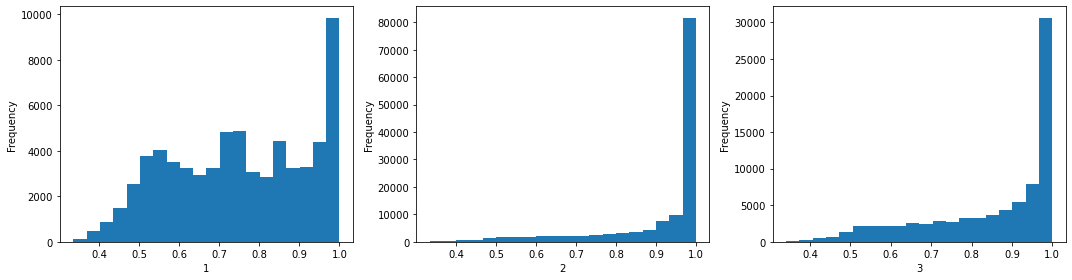

In [133]:
plot_score(result, 'sentiment', [1,2,3], 3)

## 4.3 添加可信样本

In [170]:
# 检查样本平衡
data.groupby('sentiment').count()

,Newstitle
sentiment,
1,3474
2,22588
3,4456


In [176]:
# 取样: 各30000
newsample = new_sample(total, result, 'sentiment', 20000)
newsample = newsample[newsample['sentiment']!=2]

In [179]:
data = pd.concat([data, newsample[['Newstitle', 'sentiment']]], ignore_index=True)
data.drop_duplicates(subset='Newstitle')

,Newstitle,sentiment
0,超 预期 产能 发掘 带动 营收 大幅 上升 新 项目 投资 增加 公司 成长 后劲,3
1,业 行业 景气 再 高 升值 助力 业绩 飙升,3
2,业绩 暴增 逾 两倍 股价 再 高,3
3,良好 的 业绩 保障 为 基础 资源 扩张 与 冶炼 优势 强化 并行 的 战略 推动 公司...,3
4,首旅股份 回升 带动 业绩 稳定增长 强烈推荐,3
...,...,...
70512,业绩 稳定 成长 可 期,3
70513,罗非鱼 项目 将 使 利润 增长,3
70515,特种 业绩 尚待 兑现 推荐,3
70516,发展 类似 国外 医疗 推荐,3


In [180]:
# 检查结果样本
data.groupby('sentiment').count()

,Newstitle
sentiment,
1,23474
2,22588
3,24456


In [181]:
# 输出
data.to_csv('output/sample_final.csv', index=False, encoding='utf-8-sig')

# 5 最终模型训练和保存
可以使用默认模型也可以使用自定模型

In [ ]:
data = pd.read_csv('output/sample_final.csv', encoding='utf-8-sig')

In [183]:
model = use_default_model(data['Newstitle'], data['sentiment'])

2022-05-02 21:19:09.589253: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 1/5
   6/1543 [..............................] - ETA: 18s - loss: 1.0990 - accuracy: 0.3229 

2022-05-02 21:19:11.130450: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1540/1543 [============================>.] - ETA: 0s - loss: 0.3047 - accuracy: 0.9080

2022-05-02 21:19:27.436186: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1543/1543 [==============================] - 19s 12ms/step - loss: 0.3043 - accuracy: 0.9081 - val_loss: 0.0329 - val_accuracy: 0.9950
Epoch 2/5
1543/1543 [==============================] - 19s 12ms/step - loss: 0.0161 - accuracy: 0.9970 - val_loss: 0.0116 - val_accuracy: 0.9976
Epoch 3/5
1543/1543 [==============================] - 19s 12ms/step - loss: 0.0050 - accuracy: 0.9991 - val_loss: 0.0083 - val_accuracy: 0.9979
Epoch 4/5
1543/1543 [==============================] - 19s 12ms/step - loss: 0.0021 - accuracy: 0.9996 - val_loss: 0.0068 - val_accuracy: 0.9981
Epoch 5/5
1543/1543 [==============================] - 18s 12ms/step - loss: 0.0010 - accuracy: 0.9999 - val_loss: 0.0079 - val_accuracy: 0.9978


In [185]:
result = classify(model, total['Newstitle'].to_list(), [1,2,3], 'sentiment')

2022-05-02 21:25:23.843895: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


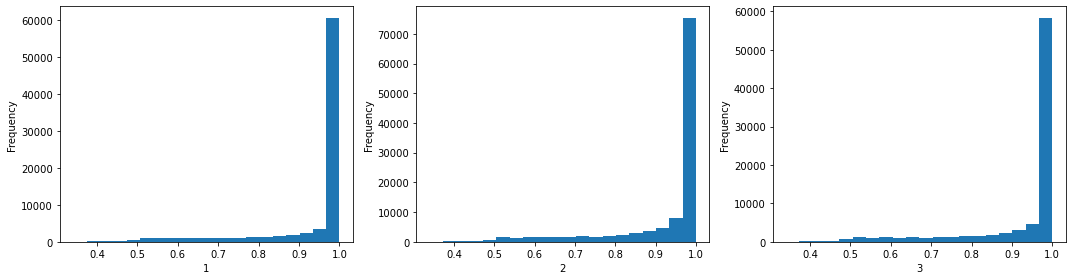

In [186]:
plot_score(result, 'sentiment', [1,2,3], 3)

In [188]:
# 结果抽检
pd.concat([total, result], axis=1).sample(30).sort_values('sentiment')

,Newstitle,1,2,3,sentiment,score
38933,* 传媒 二 股东 减持 股权,9.997755e-01,2.244697e-04,1.570565e-07,1,0.999775
68943,老 鞋匠 捡 到 元 全部 上交 被 熟人 骂 太 傻 图,9.996872e-01,3.125797e-04,2.357052e-07,1,0.999687
206131,年 月 日 最新 提示 融资 融券,9.999874e-01,1.055282e-05,1.979766e-06,1,0.999987
259030,主力 仓皇出逃 新年 破发 第 股,9.993908e-01,5.514564e-04,5.771103e-05,1,0.999391
167076,深航 加速 航线 整合 将 产生 协同效应 亿元,7.213455e-01,1.818202e-01,9.683418e-02,1,0.721346
252338,年 月 日 最新 提示 股权 转让 人事变动,1.000000e+00,2.724800e-09,1.197280e-08,1,1.000000
270817,股市 遭遇 黑色 星期二 谁 是 幕后 黑手,9.994104e-01,5.894986e-04,7.198472e-08,1,0.999410
164552,中 力促 成品油 消费税 转为 价外 征收,2.885850e-03,9.970909e-01,2.333240e-05,2,0.997091
267860,高铁 列车 目前 仍 有 足够 安全 余量,5.354878e-02,9.406748e-01,5.776417e-03,2,0.940675
244425,易 基金 新基 点评 断档 个 月 后 的 首 只 货基,2.757260e-03,9.970938e-01,1.489367e-04,2,0.997094


In [189]:
finalmodel = Sequential([model, tf.keras.layers.Softmax()])
finalmodel.save('saved_model/2010sample')

2022-05-02 21:34:32.350864: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: saved_model/2010sample/assets
